<h1> Diabetes prediction </h1>

**Important Risk Factors**

Research in the field has identified the following as important risk factors for diabetes and other chronic illnesses like heart disease (not in strict order of importance):

-     blood pressure (high)
-     cholesterol (high)
-     smoking
-     diabetes
-     obesity
-     age
-     sex
-     race
-     diet
-     exercise
-     alcohol consumption
-     BMI
-     Household Income
-     Marital Status
-     Sleep
-     Time since last checkup
-     Education
-     Health care coverage
-     Mental Health



---

<h2>Imports</h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## For statistical test
from scipy.stats import chisquare, chi2_contingency ## Stastical test
from scipy.stats import probplot
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## machine learning libary
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_fscore_support,roc_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

In [3]:
data = data[data['Age'] > 3.0].reset_index()
data["Diabetes_binary"] = np.where(data['Diabetes_012']== 0.0, 0.0, 1.0)
data.drop(columns=["Diabetes_012"],inplace = True)

In [4]:
data.head()

,index,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0.0
1,1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0
2,2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0.0
3,3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0
4,4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229259 entries, 0 to 229258
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 229259 non-null  int64  
 1   HighBP                229259 non-null  float64
 2   HighChol              229259 non-null  float64
 3   CholCheck             229259 non-null  float64
 4   BMI                   229259 non-null  float64
 5   Smoker                229259 non-null  float64
 6   Stroke                229259 non-null  float64
 7   HeartDiseaseorAttack  229259 non-null  float64
 8   PhysActivity          229259 non-null  float64
 9   Fruits                229259 non-null  float64
 10  Veggies               229259 non-null  float64
 11  HvyAlcoholConsump     229259 non-null  float64
 12  AnyHealthcare         229259 non-null  float64
 13  NoDocbcCost           229259 non-null  float64
 14  GenHlth               229259 non-null  float64
 15  

In [6]:
data.isnull().sum().any()

False

<h2>Exploratory data analysis (descriptive analysis)</h2>

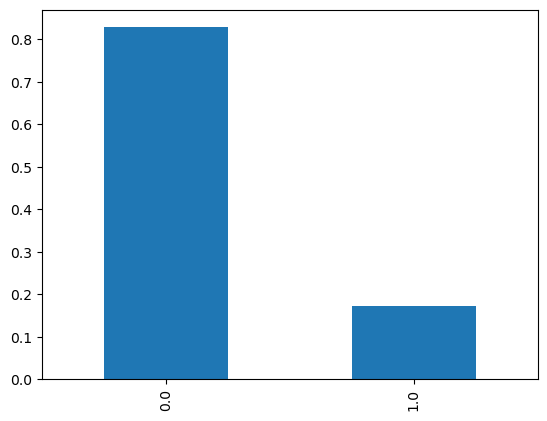

In [7]:
data['Diabetes_binary'].value_counts(normalize=True).plot(kind='bar');

Observation:

*we observe that less than 20% of the patient are with diabetes.*

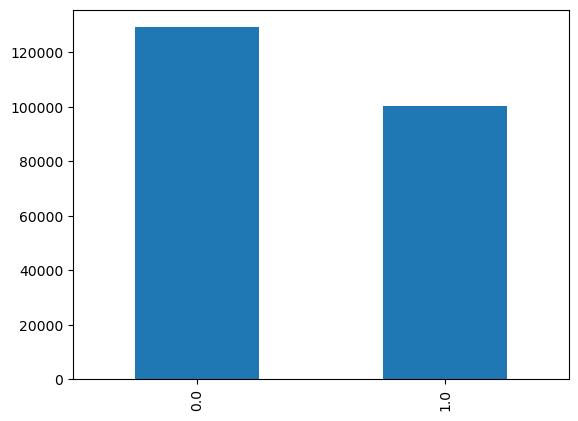

In [8]:
data['Sex'].value_counts().plot(kind='bar');

Observation:

*we have more female than male.*

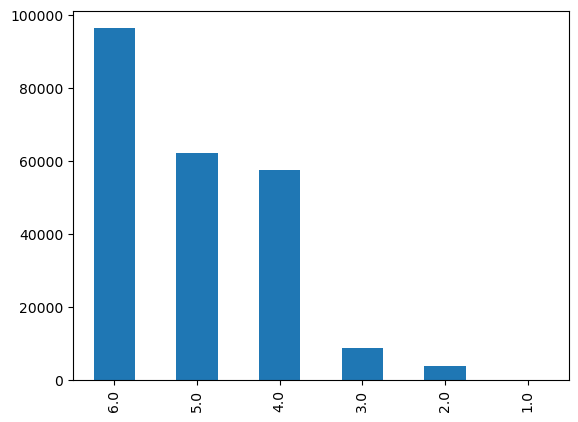

In [9]:
data['Education'].value_counts().plot(kind='bar');

Observation:

*A lot of the Respondents are educated.*

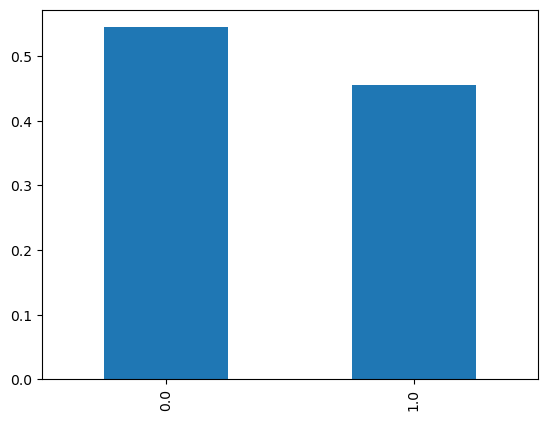

In [10]:
data['HighChol'].value_counts(normalize=True).plot(kind='bar');

Observation:

*About 45% of the Respondents have been told they have high cholesterol.*

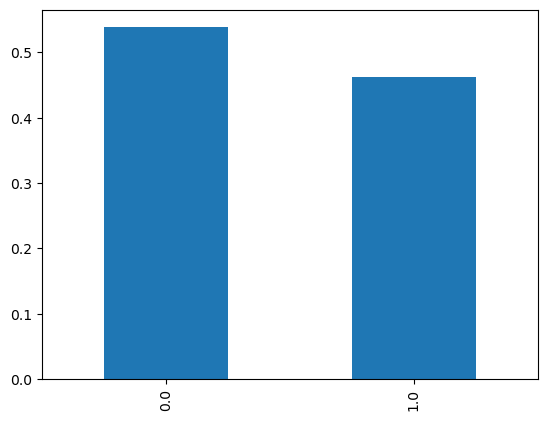

In [11]:
data['HighBP'].value_counts(normalize=True).plot(kind='bar');

Observation:

*About 45% of the Respondents have been told they have high blood pressure.*

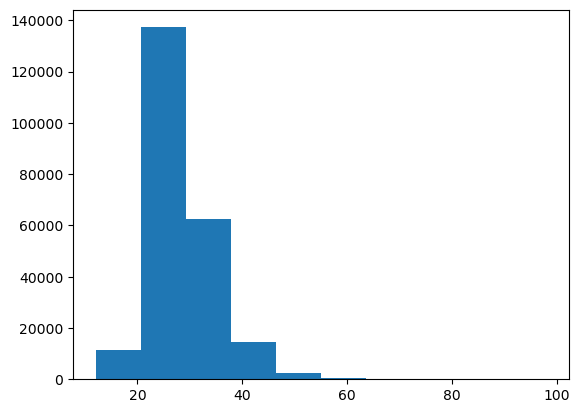

In [12]:
plt.hist(data['BMI'], bins=10);

Observation:

*A lot of Respondent BMI falls between the 20-30 range*

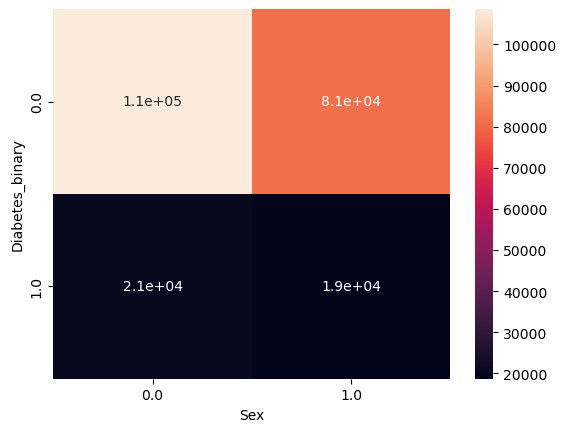

In [13]:
sns.heatmap(pd.crosstab(data['Diabetes_binary'], data['Sex']), annot=True);

Observation:

*The Gender respondents with diabetes seems not balanced, we have more females yet there are more males diabetic in this dataset.*

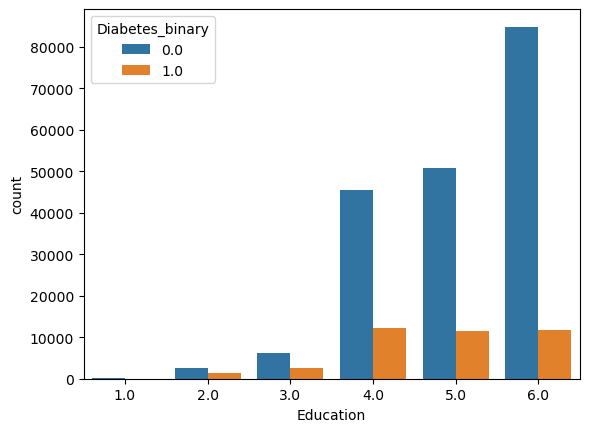

In [14]:
sns.countplot(x='Education', hue='Diabetes_binary', data=data);

Observation:

*The Education level of the respondent is not really determining if the patient has diabetes.*

<h2>Machine Learning model</h2>

In [15]:
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

In [16]:
y.value_counts(normalize=True) * 100

0.0    82.858688
1.0    17.141312
Name: Diabetes_binary, dtype: float64

In [17]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =3, stratify=y)

In [18]:
print('Shape of the X_train {}'.format(X_train.shape))
print('Shape of the y_train {}'.format(y_train.shape))
print('Shape of the X_test {}'.format(X_test.shape))
print('Shape of the y_test {}'.format(y_test.shape))

Shape of the X_train (183407, 22)
Shape of the y_train (183407,)
Shape of the X_test (45852, 22)
Shape of the y_test (45852,)


In [19]:
algos = [LogisticRegression(), 
         GaussianNB(),
         ExtraTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5,n_estimators=1000, max_features='auto', class_weight='balanced'),
        DecisionTreeClassifier(max_depth=5),
        LGBMClassifier(n_estimators=500),
         XGBClassifier(max_depth=4, n_estimators=500),]

names = ['Logistic_Regression','Guassian','ExtraTree','RandomForest','Decision_Tree', 'Lightgbm', 'Xgboost']
roc_list = []

In [20]:
for name in algos:
    model = name
    model.fit(X_train,y_train)
    y_pred = model.predict_proba(X_test)[:,1]
    score= roc_auc_score(y_test,y_pred)
    roc_list.append(score)

In [21]:
evaluation = pd.DataFrame({'Model': names,
                           'Score': roc_list})

In [22]:
evaluation = evaluation.sort_values(by='Score', ascending=False)

In [23]:
evaluation

,Model,Score
5,Lightgbm,0.812269
6,Xgboost,0.809846
3,RandomForest,0.803838
4,Decision_Tree,0.791874
1,Guassian,0.746481
2,ExtraTree,0.719351
0,Logistic_Regression,0.682426


<h2>Conclusion</h2>

After the intial training of the models, we can lift these using for example the pickle library and use them to predict and warn people that might be diabetic.